<a href="https://colab.research.google.com/github/anuragvishwakarma/Fashion-Mnist-Classification/blob/main/CNN_fashion_mnist_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Fashion Mnist/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

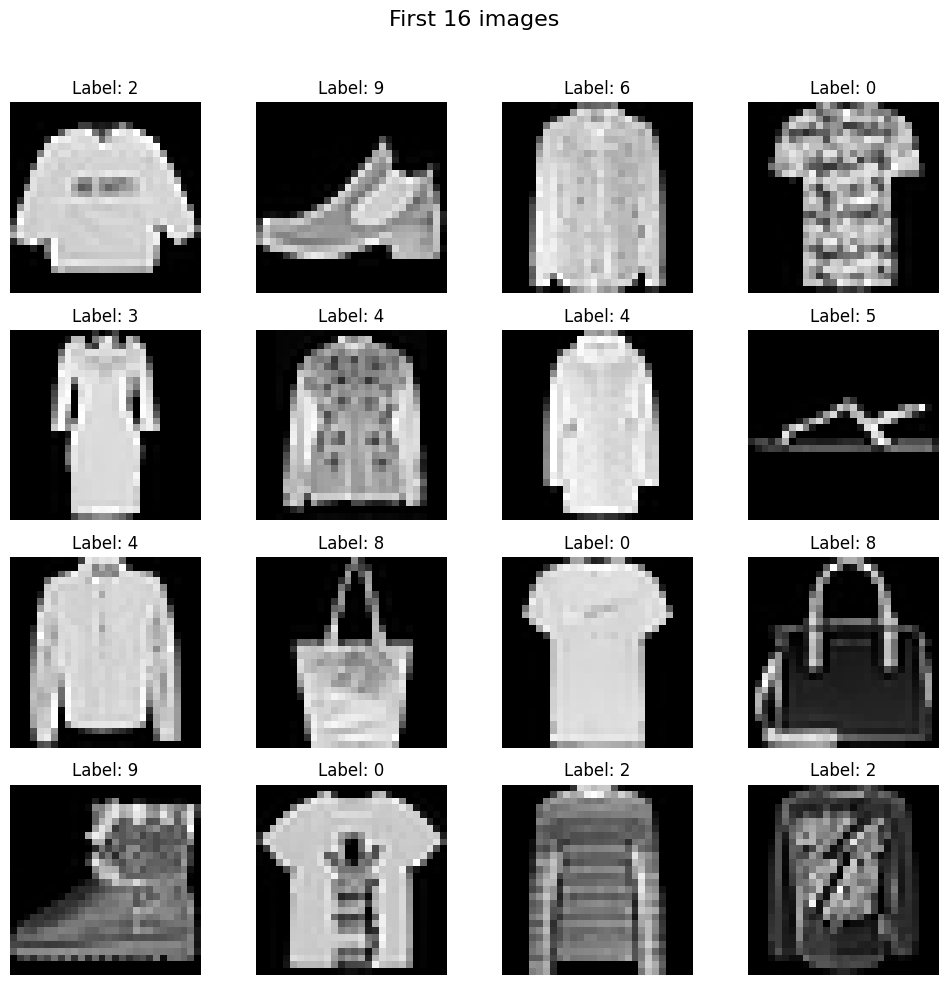

In [6]:
# Create a 4X4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('First 16 images', fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flatten()):
    img = df.iloc[i, 1:].values.reshape(28, 28) #Reshape to 28x28
    ax.imshow(img, cmap='gray') # Display in grayscale
    ax.axis('off') # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}") # Set the title to the label

plt.tight_layout(rect=[0,0,1,0.96]) # Adjust layout to fit the title
plt.show()

In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        # Convert to PyTorch tensors
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [19]:
class MyNN(nn.Module):
  def __init__(self, input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


In [20]:
learning_rate = 0.1
epochs = 100

In [21]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
# training Loop

for epoch in range(epochs):
  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data tp gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    #update grads
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f"Epoch: {epoch+1}, Loss: {avg_loss}")




Epoch: 1, Loss: 0.5848207485675812
Epoch: 2, Loss: 0.4086365614185731
Epoch: 3, Loss: 0.3519033856963118
Epoch: 4, Loss: 0.31221751624842486
Epoch: 5, Loss: 0.28581840097655853
Epoch: 6, Loss: 0.26011008639944094
Epoch: 7, Loss: 0.24958789153893787
Epoch: 8, Loss: 0.229626797751834
Epoch: 9, Loss: 0.22210811329322558
Epoch: 10, Loss: 0.2078571384505679
Epoch: 11, Loss: 0.19662805496715008
Epoch: 12, Loss: 0.18881879875746865
Epoch: 13, Loss: 0.1755982047865788
Epoch: 14, Loss: 0.17336679850860187
Epoch: 15, Loss: 0.16479715556340913
Epoch: 16, Loss: 0.1608541993331164
Epoch: 17, Loss: 0.15210791252708683
Epoch: 18, Loss: 0.15142587151293022
Epoch: 19, Loss: 0.14446282926760615
Epoch: 20, Loss: 0.13910130160876238
Epoch: 21, Loss: 0.13730477714693795
Epoch: 22, Loss: 0.12869285680780498
Epoch: 23, Loss: 0.12613979105696005
Epoch: 24, Loss: 0.12221274178133656
Epoch: 25, Loss: 0.11971664090873674
Epoch: 26, Loss: 0.11350026334709158
Epoch: 27, Loss: 0.11139819949570422
Epoch: 28, Loss: 0

In [23]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [24]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)

    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(accuracy)



0.9235833333333333


In [25]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)

    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(accuracy)


0.9982708333333333
